In [107]:
import torch
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue as prologue

import matplotlib.pyplot as plt

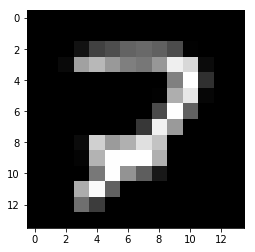

tensor([7, 3])

In [109]:
#generate train and test data
#target classes: a>b->0   a<=b->1

[train_input,train_target0,train_classes,
 test_input,test_target0,test_classes]=prologue.generate_pair_sets(1000)

#train_target = train_target.float()
train_target=torch.zeros(train_target0.size(0),2)
test_target=torch.zeros(test_target0.size(0),2)
for i in range(train_target0.size(0)):
    train_target[i,train_target0[i]]=1.0;
for i in range(test_target0.size(0)):
    test_target[i,test_target0[i]]=1.0;

fig=plt.figure(figsize=(4, 4))
plt.imshow(train_input[0,0,:,:], cmap=plt.cm.gray)  # use appropriate colormap here
plt.show()
train_classes[0,:]

In [210]:
# Conv -> maxpool -> relu
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        nb_hidden = 200
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3)
        self.fc1 = nn.Linear(8* 64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x1=torch.zeros(1000,1,14,14)   
        x2=torch.zeros(1000,1,14,14) 
        
        x1[:,0,:,:]=x[:,0,:,:]
        x2[:,0,:,:]=x[:,1,:,:]
        
        x1 = F.relu(F.max_pool2d(self.conv1(x1), kernel_size=2))
        x2 = F.relu(F.max_pool2d(self.conv1(x2), kernel_size=2))
        
        x1 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=2))
        x2 = F.relu(F.max_pool2d(self.conv2(x2), kernel_size=2))
        
        x1=x1.view(-1, 4 * 64)
        x2=x2.view(-1, 4 * 64)
        
        x=torch.cat((x1,x2),1)
 
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Conv -> relu -> maxpool
#class ConvNet2(nn.Module):
#    def __init__(self):
#        super(ConvNet2, self).__init__()
#        nb_hidden = 200
#        self.conv1 = nn.Conv2d(2, 64, kernel_size=3)
#        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
#        self.fc1 = nn.Linear(4 * 64, nb_hidden)
#        self.fc2 = nn.Linear(nb_hidden, 1)
#
#    def forward(self, x):
#        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
#        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
#        x = F.relu(self.fc1(x.view(-1, 4 * 64)))
#        x = self.fc2(x)
#        return x

In [221]:
def train_model(model, train_input, train_target, mini_batch_size):
    criterion = nn.MSELoss()
    eta = 1e-4
    nb_epochs = 100
    for e in range(nb_epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            sum_loss = sum_loss + loss.item()
            for p in model.parameters():
                p.data.sub_(eta * p.grad.data)
        print(e, sum_loss)
        
        
def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        
        for k in range(mini_batch_size):
            
            if target.data[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

In [223]:
mini_batch_size=1000;
model = ConvNet1()
train_model(model, train_input, train_target,mini_batch_size)
nb_test_errors = compute_nb_errors(model, test_input, test_target,mini_batch_size)
print('test error ConvNet {:0.2f}% {:f}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                   nb_test_errors, test_input.size(0)))

0 145.44577026367188
1 16991.455078125
2 2.479444980621338
3 1.9487388134002686
4 1.6125191450119019
5 1.3820093870162964
6 1.2145205736160278
7 1.0860204696655273
8 0.9838164448738098
9 0.9009888172149658
10 0.8327144384384155
11 0.7753196954727173
12 0.7261207699775696
13 0.6836514472961426
14 0.6466916799545288
15 0.6144295334815979
16 0.5859824419021606
17 0.560710072517395
18 0.5381730198860168
19 0.5180498957633972
20 0.5000185966491699
21 0.483742356300354
22 0.4690137207508087
23 0.4556829631328583
24 0.4435451924800873
25 0.43244266510009766
26 0.4223228394985199
27 0.41310176253318787
28 0.4046403467655182
29 0.3968775272369385
30 0.38974156975746155
31 0.3831577003002167
32 0.37708190083503723
33 0.3714817464351654
34 0.36631956696510315
35 0.3615718185901642
36 0.3571924865245819
37 0.3531360924243927
38 0.3493768274784088
39 0.34588733315467834
40 0.3426513671875
41 0.33963605761528015
42 0.3368183374404907
43 0.3341812193393707
44 0.33171984553337097
45 0.3294216394424438